# Testing WOFpy LBR sample DB
Emilio Mayorga. Run on my conda environment `uwapl_em_mc_1aui`.  
3/5,4/2017. Test Don's Amazon cloud deployment

In [1]:
%matplotlib inline

from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import pandas as pd

import ulmo
from ulmo.util import convert_datetime

/home/filipe/miniconda3/envs/BiG-CZ/lib/python2.7/site-packages/ulmo/twc/kbdi/core.py:20: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  CSV_SWITCHOVER = pandas.tslib.Timestamp('2016-10-01')


## CUAHSI WaterOneFlow: ulmo, SOAP endpoint, and other general info

In [2]:
print(ulmo.cuahsi.wof.__doc__)


    ulmo.cuahsi.wof
    ~~~~~~~~~~~~~~~

    `CUAHSI WaterOneFlow`_ web services

    .. _CUAHSI WaterOneFlow: http://his.cuahsi.org/wofws.html



In [3]:
print([obj for obj in dir(ulmo.cuahsi.wof) if not obj.startswith('__')])

['absolute_import', 'core', 'get_site_info', 'get_sites', 'get_values', 'get_variable_info']


In [26]:
# WaterML/WOF WSDL endpoints
wsdlurl = 'http://52.40.105.124:8080/odm2timeseries/soap/cuahsi_1_0/.wsdl'  # WOF 1.0

# 'network code'
networkcd = 'odm2timeseries'

## Get site information

one of two sites in the LBR sample DB

In [5]:
sitecd = 'USU-LBR-Mendon'

In [6]:
siteinfo = ulmo.cuahsi.wof.get_site_info(wsdlurl, networkcd+':'+sitecd)

In [7]:
type(siteinfo), siteinfo.keys()

(dict,
 ['code', 'name', 'series', 'notes', 'network', 'location', 'timezone_info'])

In [8]:
siteinfo['network'], siteinfo['code'], siteinfo['name']

('odm2timeseries',
 'USU-LBR-Mendon',
 'Little Bear River at Mendon Road near Mendon, Utah')

In [9]:
print(siteinfo['location'])

{'latitude': '41.718473', 'srs': 'EPSG:CUAHSI:4269', 'longitude': '-111.946402'}


In [10]:
type(siteinfo['series']), len(siteinfo['series']), siteinfo['series'].keys()

(dict,
 18,
 ['odm2timeseries:USU44',
  'odm2timeseries:USU8',
  'odm2timeseries:USU9',
  'odm2timeseries:USU6',
  'odm2timeseries:USU7',
  'odm2timeseries:USU4',
  'odm2timeseries:USU5',
  'odm2timeseries:USU3',
  'odm2timeseries:USU10',
  'odm2timeseries:USU47',
  'odm2timeseries:USU13',
  'odm2timeseries:USU48',
  'odm2timeseries:USU36',
  'odm2timeseries:USU37',
  'odm2timeseries:USU34',
  'odm2timeseries:USU35',
  'odm2timeseries:USU32',
  'odm2timeseries:USU33'])

In [11]:
siteinfo['series']['odm2timeseries:USU33'].keys()

['{http://www.cuahsi.org/water_ml/1.0/}variable_time_interval',
 '{http://www.cuahsi.org/water_ml/1.0/}_source',
 '{http://www.cuahsi.org/water_ml/1.0/}_quality_control_level',
 'variable',
 '{http://www.cuahsi.org/water_ml/1.0/}_method',
 '{http://www.cuahsi.org/water_ml/1.0/}value_count']

In [12]:
siteinfo['series']['odm2timeseries:USU33']

{'variable': {'code': 'USU33',
  'data_type': 'Unknown',
  'general_category': 'Unknown',
  'id': '33',
  'name': 'Oxygen, dissolved percent of saturation',
  'no_data_value': '-9999.0000000000',
  'sample_medium': 'Unknown',
  'time': {},
  'units': {'abbreviation': '%',
   'code': '1',
   'name': 'percent',
   'type': 'Dimensionless'},
  'value_type': 'Unknown',
  'vocabulary': 'odm2timeseries'},
 '{http://www.cuahsi.org/water_ml/1.0/}_method': {'method_description': 'Dissolved oxygen measured using a Hydrolab MS5 Water Quality Multiprobe.',
  'method_id': '19',
  'method_link': 'http://www.hydrolab.com'},
 '{http://www.cuahsi.org/water_ml/1.0/}_quality_control_level': {'quality_control_level': '0',
  'quality_control_level_id': '0'},
 '{http://www.cuahsi.org/water_ml/1.0/}_source': {},
 '{http://www.cuahsi.org/water_ml/1.0/}value_count': {'value_count': '1440'},
 '{http://www.cuahsi.org/water_ml/1.0/}variable_time_interval': {'begin_date_time': '2007-09-01T00:00:00',
  'end_date_tim

## Get Values

In [13]:
def site_series_values_to_df(series_values, variable_name):
    # Create a clean timeseries list of (dt,val) tuples
    tsdt_tuplst = [(convert_datetime(valdict['datetime']).replace(tzinfo=pytz.utc), 
                    float(valdict['value']))
                   for valdict in series_values['values']]
    
    dt, val = zip(*tsdt_tuplst)
    ts_df = pd.DataFrame({'time':dt, variable_name:val})
    ts_df.set_index('time', inplace=True)
    ts_df.sort_index(ascending=True, inplace=True)
    return ts_df

In [14]:
print(ulmo.cuahsi.wof.get_values.__doc__)


    Retrieves site values from a WaterOneFlow service using a GetValues request.

    Parameters
    ----------
    wsdl_url : str
        URL of a service's web service definition language (WSDL) description.
        All WaterOneFlow services publish a WSDL description and this url is the
        entry point to the service.
    site_code : str
        Site code of the site you'd like to get values for. Site codes MUST
        contain the network and be of the form <network>:<site_code>, as is
        required by WaterOneFlow.
    variable_code : str
        Variable code of the variable you'd like to get values for. Variable
        codes MUST contain the network and be of the form
        <vocabulary>:<variable_code>, as is required by WaterOneFlow.
    start : ``None`` or datetime (see :ref:`dates-and-times`)
        Start of a date range for a query. If both start and end parameters are
        omitted, the entire time series available will be returned.
    end : ``None`` or datet

`'odm2timeseries:USU33'` is 'Oxygen, dissolved percent of saturation'

In [15]:
variablecd = 'USU33'

site_values = ulmo.cuahsi.wof.get_values(wsdlurl, networkcd+':'+sitecd, networkcd+':'+variablecd)

In [16]:
site_values.keys()

['variable', 'quality_control_levels', 'values', 'site', 'methods']

In [17]:
sitevariable = site_values['variable']
sitevariable

{'code': 'USU33',
 'data_type': 'Unknown',
 'general_category': 'Unknown',
 'id': '33',
 'name': 'Oxygen, dissolved percent of saturation',
 'no_data_value': '-9999.0000000000',
 'sample_medium': 'Unknown',
 'time': {'interval': '30',
  'units': {'abbreviation': 'min', 'name': 'minute', 'type': 'Time'}},
 'units': {'abbreviation': '%',
  'code': '1',
  'name': 'percent',
  'type': 'Dimensionless'},
 'value_type': 'Unknown',
 'vocabulary': 'odm2timeseries'}

`site_values['values']` is a list of individual time series values (timestamp and data value)

In [18]:
type(site_values['values']), site_values['values'][0].keys()

(list,
 ['method_id', 'value', 'datetime', 'censor_code', 'quality_control_level'])

Start and end timestamps (local time with time offset vs utc; iso8601 format)

In [19]:
site_values['values'][0]['datetime'], site_values['values'][-1]['datetime']

('2007-09-01T00:00:00', '2007-09-30T23:30:00')

Set a nice, user-friendly variable name string.

In [20]:
variable_name = '%s (%s)' % (sitevariable['name'],  sitevariable['value_type'])
variable_name

'Oxygen, dissolved percent of saturation (Unknown)'

In [21]:
dtstr_last = site_values['values'][-1]['datetime']
convert_datetime(dtstr_last).replace(tzinfo=pytz.utc)

/home/filipe/miniconda3/envs/BiG-CZ/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  from ipykernel import kernelapp as app


datetime.datetime(2007, 9, 30, 23, 30, tzinfo=<UTC>)

Hmm, this failed:
```python
convert_datetime(dtstr_last).astimezone(pytz.utc)
ValueError: astimezone() cannot be applied to a naive datetime
```

In [23]:
ts_df = site_series_values_to_df(site_values, variable_name)
ts_df.tail()

/home/filipe/miniconda3/envs/BiG-CZ/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()


,"Oxygen, dissolved percent of saturation (Unknown)"
time,
2007-09-30 21:30:00+00:00,94.99999
2007-09-30 22:00:00+00:00,94.18334
2007-09-30 22:30:00+00:00,93.28333
2007-09-30 23:00:00+00:00,92.41666
2007-09-30 23:30:00+00:00,91.58334


In [24]:
type(ts_df), ts_df.columns, ts_df.index.dtype, ts_df.index.min(), ts_df.index.max()

(pandas.core.frame.DataFrame,
 Index([u'Oxygen, dissolved percent of saturation (Unknown)'], dtype='object'),
 datetime64[ns, UTC],
 Timestamp('2007-09-01 00:00:00+0000', tz='UTC'),
 Timestamp('2007-09-30 23:30:00+0000', tz='UTC'))

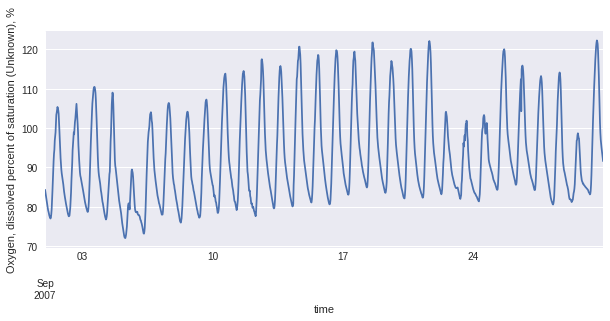

In [25]:
fig, ax = plt.subplots(figsize=(10, 4))
varlabel = ts_df.columns[0]
ts_df[varlabel].plot(style='-', ax=ax)
ax.set_ylabel(varlabel + ', ' + sitevariable['units']['abbreviation']);